In [1]:
# imports
import matplotlib.pyplot as plt
import modules.cosmos_functions as cf
import numpy as np
import torch
import torch.nn.functional as F 
import torchvision.transforms as T
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, ResNet18_Weights


In [2]:
# functions to use in the tests 

# functions to display images
def reverse_normalize(image):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = image.clone()
    for i in range(3):
        image[i] = (image[i] * std[i]) + mean[i]
    return image

def show_batch(test_d):
    # Get the first batch of data from the DataLoader
    data_test = next(iter(test_d))

    # Retrieve the first tensor and its corresponding label
    image_test = data_test[0][0]
    label_test = data_test[1][0]

    # Reverse the normalization of the image
    image_test = reverse_normalize(image_test)

    # Convert the image tensor to a NumPy array and transpose the dimensions
    np_image_test = image_test.permute(1, 2, 0).numpy()

    # Display the image
    plt.imshow(np_image_test)
    plt.title(f'{label_test}, {image_test.shape}')
    plt.axis('off')

    # Show the plot
    plt.show()

# function to test the model
def test_model(model, datasetPath):
    model.eval()    

    # Load the test dataset
    dataset_path = datasetPath
    transform = T.Compose([
        T.Resize((128, 128)),
        T.ToTensor()
                
])
    dataset = ImageFolder(dataset_path, transform=transform)
    test_dataloader = DataLoader(dataset, batch_size=120, shuffle=False)

    labels_dict = dataset.class_to_idx

    # Track the overall test accuracy and accuracy by each type of apple
    overall_correct = 0
    overall_total = 0
    normal_correct = 0
    normal_total = 0
    abnormal_correct = 0
    abnormal_total = 0

    # Initialize the confusion matrix
    num_classes = len(labels_dict)
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

    # Iterate over the test dataset
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Get predictions
        _, predicted = torch.max(outputs.data, 1)

        # Update accuracy counts
        overall_correct += (predicted == labels).sum().item()
        overall_total += labels.size(0)

        # Calculate accuracy for normal apples vs. abnormal apples
        normal_mask = labels == labels_dict['Normal_Apple']
        abnormal_mask = ~normal_mask
        normal_correct += (predicted[normal_mask] == labels[normal_mask]).sum().item()
        normal_total += normal_mask.sum().item()
        abnormal_correct += (predicted[abnormal_mask] == labels[abnormal_mask]).sum().item()
        abnormal_total += abnormal_mask.sum().item()

        # Update the confusion matrix
        for true_label, predicted_label in zip(labels.cpu().numpy(), predicted.cpu().numpy()):
            confusion_matrix[true_label][predicted_label] += 1

    # Calculate overall accuracy
    overall_accuracy = overall_correct / overall_total

    # Calculate accuracy for normal apples and abnormal apples separately
    normal_accuracy = normal_correct / normal_total if normal_total != 0 else 0.0
    abnormal_accuracy = abnormal_correct / abnormal_total if abnormal_total != 0 else 0.0

    # Print overall accuracy
    print(f"Overall accuracy: {overall_accuracy:.4f}")

    # Print accuracy for normal apples and abnormal apples separately
    print(f"Normal Apple accuracy: {normal_accuracy:.4f}")
    print(f"Abnormal Apple accuracy: {abnormal_accuracy:.4f}")

    # Print the confusion matrix
    print()
    print(labels_dict)
    print("Confusion Matrix:")
    print(confusion_matrix)


In [3]:
# set the device

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
x = torch.ones(1, device=device)

print(f"Device is '{device}' Thus a tensor will look like this: {x}")

Device is 'mps' Thus a tensor will look like this: tensor([1.], device='mps:0')


In [4]:
# add the resnet18 model for testing the test dataset with the trained model
# import the resnet18 model

weights = ResNet18_Weights.DEFAULT  #weights=ResNet18_Weights.IMAGENET1K_V1 is the current default
model = resnet18(weights=weights)  

# freeze the model parameters
for param in model.parameters():
    param.requires_grad = False
    
# change the last layer of the model to fit the number of classes in the dataset
model.fc = nn.Linear(512, 4)
    
# change the last layer of the model to fit the number of classes in the dataset
model.fc = nn.Linear(512, 4)



In [5]:
# # Show the 1st img in the dataset
# show_batch(test_d)
# print(test_dataset[0][0])

In [6]:

# imported_model_path = "../storage/data/generated/20230605-134750_pinky_acc.pt"  # high accuracy
# imported_model_path = cf.load_pth('20230605_160852_pinky')  # issues; WIP
# imported_model_path 


In [7]:
# Load the test dataset
dataset_path = "../storage/images/apple_resized_128/Test"

# import the model state
imported_model_state_path = "../storage/data/generated/20230608-233306_pinky_acc.pt"   # test to 128x128 accuracy

# load the model state into the model
model_state_import_path = imported_model_state_path
model.load_state_dict(torch.load(model_state_import_path))
model.to(device)





test_model(model, dataset_path)

Overall accuracy: 0.6917
Normal Apple accuracy: 0.2500
Abnormal Apple accuracy: 0.8021

{'Blotch_Apple': 0, 'Normal_Apple': 1, 'Rot_Apple': 2, 'Scab_Apple': 3}
Confusion Matrix:
[[25  0  0  5]
 [11  6  1  6]
 [ 0  0 36  2]
 [ 5  1  6 16]]


In [8]:
# Load the test dataset
dataset_path = "../storage/images/apple_resized_128/Test"

# import the model state
imported_model_state_path = "../storage/data/generated/20230608-233306_pinky_loss.pt"   # test to 128x128 loss

# load the model state into the model
model_state_import_path = imported_model_state_path
model.load_state_dict(torch.load(model_state_import_path))
model.to(device)





test_model(model, dataset_path)


Overall accuracy: 0.7583
Normal Apple accuracy: 0.5000
Abnormal Apple accuracy: 0.8229

{'Blotch_Apple': 0, 'Normal_Apple': 1, 'Rot_Apple': 2, 'Scab_Apple': 3}
Confusion Matrix:
[[27  0  1  2]
 [ 6 12  1  5]
 [ 0  1 36  1]
 [ 4  5  3 16]]


In [9]:
# Load the test dataset
dataset_path = "../storage/images/apple_disease_classification_unedited/Test"

# import the model state
imported_model_state_path = "../storage/data/generated/20230608-233306_pinky_acc.pt"   # test to 128x128 accuracy

# load the model state into the model
model_state_import_path = imported_model_state_path
model.load_state_dict(torch.load(model_state_import_path))
model.to(device)




print ('higest accuracy model')
test_model(model, dataset_path)

higest accuracy model
Overall accuracy: 0.7083
Normal Apple accuracy: 0.2917
Abnormal Apple accuracy: 0.8125

{'Blotch_Apple': 0, 'Normal_Apple': 1, 'Rot_Apple': 2, 'Scab_Apple': 3}
Confusion Matrix:
[[25  0  0  5]
 [10  7  1  6]
 [ 0  0 36  2]
 [ 5  1  5 17]]


In [10]:
# Load the test dataset
dataset_path = "../storage/images/apple_disease_classification_unedited/Test"

# import the model state
imported_model_state_path = "../storage/data/generated/20230608-233306_pinky_loss.pt"   # test to 128x128 loss

# load the model state into the model
model_state_import_path = imported_model_state_path
model.load_state_dict(torch.load(model_state_import_path))
model.to(device)




print('lowest loss model')
test_model(model, dataset_path)


lowest loss model
Overall accuracy: 0.7500
Normal Apple accuracy: 0.5417
Abnormal Apple accuracy: 0.8021

{'Blotch_Apple': 0, 'Normal_Apple': 1, 'Rot_Apple': 2, 'Scab_Apple': 3}
Confusion Matrix:
[[27  0  1  2]
 [ 5 13  1  5]
 [ 0  1 36  1]
 [ 5  4  5 14]]


In [11]:
# Load the test dataset
dataset_path = "../storage/images/apple_disease_classification_unedited/Test"

# import the model state
imported_model_state_path = "../storage/data/generated/20230608-233306_pinky_final.pt"   # test to 128x128 loss

# load the model state into the model
model_state_import_path = imported_model_state_path
model.load_state_dict(torch.load(model_state_import_path))
model.to(device)




print("Final model")
test_model(model, dataset_path)

Final model
Overall accuracy: 0.7000
Normal Apple accuracy: 0.1667
Abnormal Apple accuracy: 0.8333

{'Blotch_Apple': 0, 'Normal_Apple': 1, 'Rot_Apple': 2, 'Scab_Apple': 3}
Confusion Matrix:
[[25  0  0  5]
 [12  4  1  7]
 [ 0  0 36  2]
 [ 3  2  4 19]]


In [12]:
# Load the test dataset
dataset_path = "../storage/images/apple_disease_classification_unedited/Test"

# import the model state
imported_model_state_path = "../storage/data/generated/model_safe_final"   # test to 128x128 loss

# load the model state into the model
model_state_import_path = imported_model_state_path
model.load_state_dict(torch.load(model_state_import_path))
model.to(device)




print("model_safe_final")
test_model(model, dataset_path)

model_safe_final
Overall accuracy: 0.7250
Normal Apple accuracy: 0.5833
Abnormal Apple accuracy: 0.7604

{'Blotch_Apple': 0, 'Normal_Apple': 1, 'Rot_Apple': 2, 'Scab_Apple': 3}
Confusion Matrix:
[[16  0  0 14]
 [ 5 14  1  4]
 [ 0  1 34  3]
 [ 2  1  2 23]]


In [13]:
# Load the test dataset
dataset_path = "../storage/images/apple_resized_128/Test"

# import the model state
imported_model_state_path = "../storage/data/generated/model_safe_final"   # test to 128x128 loss

# load the model state into the model
model_state_import_path = imported_model_state_path
model.load_state_dict(torch.load(model_state_import_path))
model.to(device)




print("model_safe_final")
test_model(model, dataset_path)

model_safe_final
Overall accuracy: 0.7250
Normal Apple accuracy: 0.5833
Abnormal Apple accuracy: 0.7604

{'Blotch_Apple': 0, 'Normal_Apple': 1, 'Rot_Apple': 2, 'Scab_Apple': 3}
Confusion Matrix:
[[17  1  0 12]
 [ 2 14  1  7]
 [ 0  1 34  3]
 [ 3  1  2 22]]


In [14]:
# Load the test dataset
dataset_path = "../storage/images/apple_disease_classification_unedited/Test"

# import the model state
imported_model_state_path = "../storage/data/generated/model_safe_final"   # test to 128x128 loss

# load the model state into the model
model_state_import_path = imported_model_state_path
model.load_state_dict(torch.load(model_state_import_path))
model.to(device)




print("model_safe_final_2")
test_model(model, dataset_path)

model_safe_final_2
Overall accuracy: 0.7250
Normal Apple accuracy: 0.5833
Abnormal Apple accuracy: 0.7604

{'Blotch_Apple': 0, 'Normal_Apple': 1, 'Rot_Apple': 2, 'Scab_Apple': 3}
Confusion Matrix:
[[16  0  0 14]
 [ 5 14  1  4]
 [ 0  1 34  3]
 [ 2  1  2 23]]


In [15]:
# Load the test dataset
dataset_path = "../storage/images/apple_resized_128/Test"

# import the model state
imported_model_state_path = "../storage/data/generated/model_safe_final"   # test to 128x128 loss

# load the model state into the model
model_state_import_path = imported_model_state_path
model.load_state_dict(torch.load(model_state_import_path))
model.to(device)




print("model_safe_final_2")
test_model(model, dataset_path)

model_safe_final_2
Overall accuracy: 0.7250
Normal Apple accuracy: 0.5833
Abnormal Apple accuracy: 0.7604

{'Blotch_Apple': 0, 'Normal_Apple': 1, 'Rot_Apple': 2, 'Scab_Apple': 3}
Confusion Matrix:
[[17  1  0 12]
 [ 2 14  1  7]
 [ 0  1 34  3]
 [ 3  1  2 22]]


In [82]:

import matplotlib.pyplot as plt

def diffImage(image1, image2):
    # Calculate the absolute difference between the two images
    diff = np.abs(image1 - image2)
    return diff

def imageNumber(image1):
    # Calculate the absolute difference between the two images
    image_number = image1.sum()
    return image_number

def display_images(image1, image2):
    # Calculate the absolute difference between the two images
    diff = diffImage(image1,image2)
   

    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    # Display image 1
    axes[0].imshow(image1, cmap='gray')
    axes[0].set_title(f'{imageNumber(image1)}')

    # Display image 2
    axes[1].imshow(image2, cmap='gray')
    axes[1].set_title(f'{imageNumber(image2)}')

    # Display the difference image
    axes[2].imshow(diff, cmap='gray')
    axes[2].set_title(f'{imageNumber(diff)}')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

def dataLoaderT(datasetPath):
    # Load the test dataset
    dataset_path = datasetPath
    transform = T.Compose([
        T.Resize((128, 128)),
        T.ToTensor()])
    dataset = ImageFolder(dataset_path, transform=transform)
    test_dataloader = DataLoader(dataset, batch_size=120, shuffle=False)
    return test_dataloader




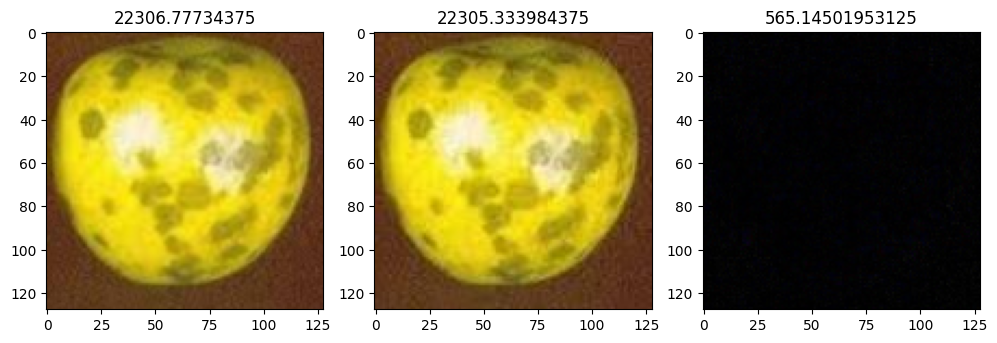

In [93]:
dataset_path_unedited = "../storage/images/apple_disease_classification_unedited/Test"
dataset_path_resized = "../storage/images/apple_resized_128/Test"

test_dataloader_unedited = dataLoaderT(dataset_path_unedited)
test_dataloader_resized = dataLoaderT(dataset_path_resized)

# Retrieve the first batch of data from the DataLoader
data_unedited = next(iter(test_dataloader_unedited))
data_resized = next(iter(test_dataloader_resized))

random1 = np.random.randint(0, 120)
random2 = np.random.randint(0, 120)
unedited_image = data_unedited[0][random1]
resized_image = data_resized[0][random1]

# Convert the images to NumPy arrays
unedited_image = unedited_image.permute(1, 2, 0).numpy()
resized_image = resized_image.permute(1, 2, 0).numpy()

# Display the images
display_images(unedited_image, resized_image)
